## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import VAE

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=20, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
CAT_IDX = 0
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161772,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
161774,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
161775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.03)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

# Standardize the input data from -1 to 1 for numerical variables
scaler_train = skpre.MinMaxScaler()
scaler_test = skpre.MinMaxScaler()

# Separate the scaling for train/test so that no overall mean/std info is carried
# train_data[:,:CAT_IDX] = scaler_train.fit_transform(train_data[:,:CAT_IDX])
# test_data[:,:CAT_IDX] = scaler_test.fit_transform(test_data[:,:CAT_IDX])

print(f"Training on {train_idx} samples")

Training on 4218 samples


## Set Parameters and Define Model

In [7]:
# Grid Search 1
# BATCH_SIZES = [1024, 512, 256, 128, 64, 32]
# EPOCHS = [20]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [8,16,32,64]
# KL_WEIGHTS = [0.01,0.05,0.1,0.5]
# [14.05646538734436, <tf.Tensor: shape=(), dtype=float32, numpy=1.9191134>, <tf.Tensor: shape=(), dtype=float32, numpy=3.025887>, KstestResult(statistic=0.5773528502126812, pvalue=0.0), Power_divergenceResult(statistic=122581.11806601255, pvalue=0.0), [1024, 20, 2, 32, 0.01]]
# [11.231985330581665, <tf.Tensor: shape=(), dtype=float32, numpy=40.03866>, <tf.Tensor: shape=(), dtype=float32, numpy=4.05524>, KstestResult(statistic=0.41753790846883754, pvalue=0.0), Power_divergenceResult(statistic=122300.09878929473, pvalue=0.0), [1024, 20, 2, 8, 0.01]]
# [11.231985330581665, <tf.Tensor: shape=(), dtype=float32, numpy=40.03866>, <tf.Tensor: shape=(), dtype=float32, numpy=4.05524>, KstestResult(statistic=0.41753790846883754, pvalue=0.0), Power_divergenceResult(statistic=122300.09878929473, pvalue=0.0), [1024, 20, 2, 8, 0.01]]

# Grid Search 2
# BATCH_SIZES = [4096, 2048, 1024, 512]
# EPOCHS = [20, 40]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [4, 8, 16, 32]
# KL_WEIGHTS = [.001, .005, 0.01, 0.05]
# [26.794755935668945, <tf.Tensor: shape=(), dtype=float32, numpy=2.0033364>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1165783>, KstestResult(statistic=0.6072337345112601, pvalue=0.0), Power_divergenceResult(statistic=122765.4937961509, pvalue=0.0), [1024, 40, 2, 32, 0.005]]
# [7.162848949432373, <tf.Tensor: shape=(), dtype=float32, numpy=42.918358>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0970073>, KstestResult(statistic=0.3970379084688376, pvalue=0.0), Power_divergenceResult(statistic=123332.1501197664, pvalue=0.0), [4096, 20, 2, 4, 0.001]]
# [7.162848949432373, <tf.Tensor: shape=(), dtype=float32, numpy=42.918358>, <tf.Tensor: shape=(), dtype=float32, numpy=5.0970073>, KstestResult(statistic=0.3970379084688376, pvalue=0.0), Power_divergenceResult(statistic=123332.1501197664, pvalue=0.0), [4096, 20, 2, 4, 0.001]]

# Grid Search 3
# BATCH_SIZES = [2048, 1024, 512]
# EPOCHS = [100]
# LATENT_DIMS = [2]
# HIDDEN_DIMS = [8, 16, 32]
# KL_WEIGHTS = [.001, .005, .01, .03, .05, .07, .1]
# NUM_WEIGHTS = [1, 5, 10, 15, 20]
# [69.22298073768616, <tf.Tensor: shape=(), dtype=float32, numpy=0.7053668>, <tf.Tensor: shape=(), dtype=float32, numpy=2.433684>, KstestResult(statistic=0.3483799112287141, pvalue=0.0), Power_divergenceResult(statistic=121453.35289829638, pvalue=0.0), [512, 100, 2, 16, 0.03, 20]]
# [39.46292066574097, <tf.Tensor: shape=(), dtype=float32, numpy=4.3707395>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2804358>, KstestResult(statistic=0.6909941373963269, pvalue=0.0), Power_divergenceResult(statistic=121742.847546511, pvalue=0.0), [2048, 100, 2, 8, 0.001, 1]]
# [39.46292066574097, <tf.Tensor: shape=(), dtype=float32, numpy=4.3707395>, <tf.Tensor: shape=(), dtype=float32, numpy=3.2804358>, KstestResult(statistic=0.6909941373963269, pvalue=0.0), Power_divergenceResult(statistic=121742.847546511, pvalue=0.0), [2048, 100, 2, 8, 0.001, 1]]

# Grid Search 4
# BATCH_SIZES = [512]
# EPOCHS = [100]
# LATENT_DIMS = [3]
# HIDDEN_DIMS = [8, 16, 32]
# KL_WEIGHTS = [.05, .1, .5, 1.0]
# NUM_WEIGHTS = [.5, 1, 2, 5, 10, 15]
# [90.3771698474884, <tf.Tensor: shape=(), dtype=float32, numpy=1.9142284>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91689825>, KstestResult(statistic=0.2516518330416969, pvalue=0.0), Power_divergenceResult(statistic=121336.76842914447, pvalue=0.0), [512, 100, 3, 32, 0.05, 2]]
# [67.4782133102417, <tf.Tensor: shape=(), dtype=float32, numpy=8.163122>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749605>, KstestResult(statistic=0.27553862404506846, pvalue=0.0), Power_divergenceResult(statistic=121310.24485971738, pvalue=0.0), [512, 100, 3, 8, 0.05, 0.5]]
# [67.4782133102417, <tf.Tensor: shape=(), dtype=float32, numpy=8.163122>, <tf.Tensor: shape=(), dtype=float32, numpy=1.3749605>, KstestResult(statistic=0.27553862404506846, pvalue=0.0), Power_divergenceResult(statistic=121310.24485971738, pvalue=0.0), [512, 100, 3, 8, 0.05, 0.5]]

BATCH_SIZE = 256
EPOCHS = 1000
LATENT_DIM = 3
HIDDEN_DIM = 16
KL_WEIGHT = .05
NUM_WEIGHT = 1


# Best results so far:
# As the training size gets smaller, KL weight should decrease [.01-.1 seems good range]
# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 16
# KL_WEIGHT = .05
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 32
# KL_WEIGHT = .05
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 3
# HIDDEN_DIM = 16
# KL_WEIGHT = .1
# NUM_WEIGHT = 2

# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 2
# HIDDEN_DIM = 16
# KL_WEIGHT = .04
# NUM_WEIGHT = 10

# # Borysov
# BATCH_SIZE = 64
# EPOCHS = 10
# LEARN_RATE = 0.001
# RHO = 0.9
# LATENT_DIM = 5
# HIDDEN_DIM = 100
# KL_WEIGHT = 0.5

# Lower KLLW gives better reconstruction on the test data
# Too low KLLW gives nonsense in the synthesis
# Get KLLW as low as possible before synthesis suffers

## Training

In [8]:
# # Run the model on the test data and get loss, then generate synthetic population and get test statistics
# def test_model(vae, LATENT_DIM):
#     results = vae.predict(test_data)
#     loss_num, loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)

#     POP_SIZE = 10000  # Number of hh in WA
#     inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))
#     results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])
#     # Transform continuous/categorical variables back to real values in the results and test data
#     if len(CAT_LENGTHS) > 0:  
#         # Handle case where are categorical variables
#         results_num = scaler_train.inverse_transform(results[0])
#         test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
#         results_df = pd.DataFrame(results_num)
#         test_data_df = pd.DataFrame(test_data_num)

#         # Argmax for each categorical variable the results data
#         for i, x in enumerate(results[1]):
#             result = np.argmax(x, axis=1) + 1
#             results_df[f"{i}"] = result

#         # Argmax for each categorical variable the test data
#         current = CAT_IDX
#         for i, x in enumerate(CAT_LENGTHS):
#             test_data_cat = test_data[:,current:(current + x)]
#             test_data_cat = np.argmax(test_data_cat, axis=1) + 1
#             test_data_df[f"{i}"] = test_data_cat
#             current += x
#     else:
#         # Handle case where there are no categorical variables
#         results_num = scaler_train.inverse_transform(results)
#         test_data_num = scaler_test.inverse_transform(test_data)
#         results_df = pd.DataFrame(results_num)
#         test_data_df = pd.DataFrame(test_data_num)
#     # Add back original variables names to the results
#     results_df.columns = VAR_NAMES
#     test_data_df.columns = VAR_NAMES
#     # In the PUMS data, VEH is indexed from 0 (sensibly). However we have just added 1 to all cat vars, so remove it
#     results_df['VEH'] = results_df['VEH'] - 1
    
#     for i in range(CAT_IDX):
#         ks_test = stats.ks_2samp(results_df.values[:,i], pums_data.values[:,i])
#     for i in range(CAT_IDX, results_df.values.shape[1]):
#         unique_values, count_in_pums = np.unique(pums_data.values[:,i].astype('int'), return_counts=True)
#         count_in_results = []
#         for value in unique_values:
#             count_in_results.append(np.count_nonzero(results_df.values[:,i].astype('int') == value))
#         chisq_test = stats.chisquare(count_in_results, f_exp=count_in_pums)

#     return loss_num, loss_cat, ks_test, chisq_test

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     for nw in NUM_WEIGHTS:
#                         start_time = time.time()
#                         LEN_HH = 0
#                         vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, CAT_IDX, LEN_HH, klw, nw)
#                         vae.compile(optimizer=keras.optimizers.Adam())
#                         history = vae.fit(train_data, epochs=e, batch_size=bs)
#                         train_time = (time.time()-start_time)
#                         loss_num, loss_cat, ks_test, chisq_test = test_model(vae, ld)
#                         results = [train_time, loss_num, loss_cat, ks_test, chisq_test, [bs,e,ld,hd,klw,nw]]
#                         grid_search_results.append(results)
# # results = [train_time, loss_num, loss_cat, ks_test, chisq_test, [bs,e,ld,hd,klw]]
# min_rec = 0
# min_ks = 0
# min_chisq = 0
# min_rec_value = 999999999
# min_ks_value = 999999999
# min_chisq_value = 999999999
# for i, result in enumerate(grid_search_results):
#     if result[1]+result[2] < min_rec_value:
#         min_rec = i
#         min_rec_value = result[1]+result[2]
#     if result[3][1] < min_ks_value:
#         min_ks = i
#         min_ks_value = result[3][1]
#     if result[4][1] < min_chisq_value:
#         min_chisq = i
#         min_chisq_value = result[4][1]
# print(grid_search_results[min_rec])
# print(grid_search_results[min_ks])
# print(grid_search_results[min_chisq])

Epoch 1/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 11.6503 - rec_loss: 11.6351 - kl_loss: 0.0151
Epoch 2/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 11.0607 - rec_loss: 11.0396 - kl_loss: 0.0211
Epoch 3/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 10.4338 - rec_loss: 10.3838 - kl_loss: 0.0499
Epoch 4/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 9.6928 - rec_loss: 9.5869 - kl_loss: 0.1059
Epoch 5/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 8.9796 - rec_loss: 8.8168 - kl_loss: 0.1629
Epoch 6/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 8.4234 - rec_loss: 8.2387 - kl_loss: 0.1847
Epoch 7/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 7.9979 - rec_loss: 7.8151 - kl_loss: 0.1828
Epoch 8/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 7.6391 - rec_loss: 7.4493 - kl_loss: 0.1898
Epoch 9/1000
17/17

17/17 [==============================] - 0s 4ms/step - tot_loss: 5.0223 - rec_loss: 4.7296 - kl_loss: 0.2927
Epoch 68/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 5.0135 - rec_loss: 4.7202 - kl_loss: 0.2933
Epoch 69/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.9948 - rec_loss: 4.7005 - kl_loss: 0.2943
Epoch 70/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 4.9844 - rec_loss: 4.6885 - kl_loss: 0.2959
Epoch 71/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.9564 - rec_loss: 4.6590 - kl_loss: 0.2973
Epoch 72/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.9492 - rec_loss: 4.6509 - kl_loss: 0.2983
Epoch 73/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.9308 - rec_loss: 4.6316 - kl_loss: 0.2992
Epoch 74/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.9161 - rec_loss: 4.6161 - kl_loss: 0.3000
Epoch 75/1000
17/17 [=========

17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0874 - rec_loss: 3.7410 - kl_loss: 0.3463
Epoch 134/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0758 - rec_loss: 3.7292 - kl_loss: 0.3466
Epoch 135/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0777 - rec_loss: 3.7302 - kl_loss: 0.3476
Epoch 136/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0514 - rec_loss: 3.7028 - kl_loss: 0.3486
Epoch 137/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0395 - rec_loss: 3.6916 - kl_loss: 0.3480
Epoch 138/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0340 - rec_loss: 3.6850 - kl_loss: 0.3489
Epoch 139/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0154 - rec_loss: 3.6658 - kl_loss: 0.3497
Epoch 140/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 4.0080 - rec_loss: 3.6584 - kl_loss: 0.3495
Epoch 141/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4701 - rec_loss: 3.0874 - kl_loss: 0.3828
Epoch 200/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4611 - rec_loss: 3.0774 - kl_loss: 0.3837
Epoch 201/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4641 - rec_loss: 3.0801 - kl_loss: 0.3840
Epoch 202/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4624 - rec_loss: 3.0788 - kl_loss: 0.3835
Epoch 203/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4578 - rec_loss: 3.0730 - kl_loss: 0.3848
Epoch 204/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4383 - rec_loss: 3.0521 - kl_loss: 0.3862
Epoch 205/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4376 - rec_loss: 3.0528 - kl_loss: 0.3849
Epoch 206/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.4274 - rec_loss: 3.0427 - kl_loss: 0.3847
Epoch 207/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1552 - rec_loss: 2.7494 - kl_loss: 0.4058
Epoch 266/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1417 - rec_loss: 2.7339 - kl_loss: 0.4079
Epoch 267/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1498 - rec_loss: 2.7409 - kl_loss: 0.4090
Epoch 268/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1466 - rec_loss: 2.7393 - kl_loss: 0.4072
Epoch 269/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1365 - rec_loss: 2.7294 - kl_loss: 0.4071
Epoch 270/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1332 - rec_loss: 2.7239 - kl_loss: 0.4092
Epoch 271/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1340 - rec_loss: 2.7246 - kl_loss: 0.4094
Epoch 272/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 3.1288 - rec_loss: 2.7189 - kl_loss: 0.4099
Epoch 273/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9356 - rec_loss: 2.5109 - kl_loss: 0.4247
Epoch 332/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9244 - rec_loss: 2.4993 - kl_loss: 0.4251
Epoch 333/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9260 - rec_loss: 2.4993 - kl_loss: 0.4267
Epoch 334/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9302 - rec_loss: 2.5036 - kl_loss: 0.4265
Epoch 335/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9239 - rec_loss: 2.4974 - kl_loss: 0.4265
Epoch 336/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9147 - rec_loss: 2.4875 - kl_loss: 0.4272
Epoch 337/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9132 - rec_loss: 2.4869 - kl_loss: 0.4264
Epoch 338/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.9094 - rec_loss: 2.4835 - kl_loss: 0.4260
Epoch 339/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.7785 - rec_loss: 2.3400 - kl_loss: 0.4385
Epoch 398/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.7813 - rec_loss: 2.3408 - kl_loss: 0.4405
Epoch 399/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.7505 - rec_loss: 2.3121 - kl_loss: 0.4384
Epoch 400/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.7684 - rec_loss: 2.3318 - kl_loss: 0.4365
Epoch 401/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.7509 - rec_loss: 2.3141 - kl_loss: 0.4369
Epoch 402/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 2.7527 - rec_loss: 2.3150 - kl_loss: 0.4377
Epoch 403/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 2.7581 - rec_loss: 2.3180 - kl_loss: 0.4401
Epoch 404/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 2.7520 - rec_loss: 2.3117 - kl_loss: 0.4402
Epoch 405/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6314 - rec_loss: 2.1818 - kl_loss: 0.4497
Epoch 464/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6188 - rec_loss: 2.1668 - kl_loss: 0.4521
Epoch 465/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6281 - rec_loss: 2.1790 - kl_loss: 0.4491
Epoch 466/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6224 - rec_loss: 2.1754 - kl_loss: 0.4470
Epoch 467/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6179 - rec_loss: 2.1695 - kl_loss: 0.4484
Epoch 468/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6139 - rec_loss: 2.1646 - kl_loss: 0.4493
Epoch 469/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6144 - rec_loss: 2.1658 - kl_loss: 0.4486
Epoch 470/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.6184 - rec_loss: 2.1689 - kl_loss: 0.4495
Epoch 471/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.5067 - rec_loss: 2.0515 - kl_loss: 0.4552
Epoch 530/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.5014 - rec_loss: 2.0449 - kl_loss: 0.4565
Epoch 531/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.4973 - rec_loss: 2.0400 - kl_loss: 0.4573
Epoch 532/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.4977 - rec_loss: 2.0409 - kl_loss: 0.4568
Epoch 533/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.5020 - rec_loss: 2.0465 - kl_loss: 0.4554
Epoch 534/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.4942 - rec_loss: 2.0375 - kl_loss: 0.4567
Epoch 535/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.4894 - rec_loss: 2.0316 - kl_loss: 0.4579
Epoch 536/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.4944 - rec_loss: 2.0364 - kl_loss: 0.4580
Epoch 537/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3913 - rec_loss: 1.9280 - kl_loss: 0.4632
Epoch 596/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3963 - rec_loss: 1.9326 - kl_loss: 0.4637
Epoch 597/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3840 - rec_loss: 1.9216 - kl_loss: 0.4625
Epoch 598/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3898 - rec_loss: 1.9271 - kl_loss: 0.4627
Epoch 599/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3850 - rec_loss: 1.9216 - kl_loss: 0.4634
Epoch 600/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3936 - rec_loss: 1.9295 - kl_loss: 0.4640
Epoch 601/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3898 - rec_loss: 1.9259 - kl_loss: 0.4638
Epoch 602/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.3940 - rec_loss: 1.9290 - kl_loss: 0.4650
Epoch 603/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2948 - rec_loss: 1.8288 - kl_loss: 0.4660
Epoch 662/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2989 - rec_loss: 1.8334 - kl_loss: 0.4655
Epoch 663/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2995 - rec_loss: 1.8318 - kl_loss: 0.4677
Epoch 664/1000
17/17 [==============================] - 0s 3ms/step - tot_loss: 2.3013 - rec_loss: 1.8340 - kl_loss: 0.4673
Epoch 665/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2975 - rec_loss: 1.8306 - kl_loss: 0.4669
Epoch 666/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2872 - rec_loss: 1.8185 - kl_loss: 0.4687
Epoch 667/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2902 - rec_loss: 1.8211 - kl_loss: 0.4690
Epoch 668/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2897 - rec_loss: 1.8214 - kl_loss: 0.4683
Epoch 669/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2050 - rec_loss: 1.7337 - kl_loss: 0.4713
Epoch 728/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2050 - rec_loss: 1.7339 - kl_loss: 0.4711
Epoch 729/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1912 - rec_loss: 1.7202 - kl_loss: 0.4710
Epoch 730/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2022 - rec_loss: 1.7324 - kl_loss: 0.4699
Epoch 731/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1989 - rec_loss: 1.7292 - kl_loss: 0.4697
Epoch 732/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.2038 - rec_loss: 1.7355 - kl_loss: 0.4683
Epoch 733/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1994 - rec_loss: 1.7295 - kl_loss: 0.4699
Epoch 734/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1942 - rec_loss: 1.7238 - kl_loss: 0.4704
Epoch 735/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1186 - rec_loss: 1.6443 - kl_loss: 0.4743
Epoch 794/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1218 - rec_loss: 1.6478 - kl_loss: 0.4740
Epoch 795/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1252 - rec_loss: 1.6506 - kl_loss: 0.4746
Epoch 796/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1247 - rec_loss: 1.6487 - kl_loss: 0.4760
Epoch 797/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1178 - rec_loss: 1.6425 - kl_loss: 0.4753
Epoch 798/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1161 - rec_loss: 1.6411 - kl_loss: 0.4750
Epoch 799/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1248 - rec_loss: 1.6497 - kl_loss: 0.4752
Epoch 800/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.1152 - rec_loss: 1.6400 - kl_loss: 0.4751
Epoch 801/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0469 - rec_loss: 1.5691 - kl_loss: 0.4778
Epoch 860/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0459 - rec_loss: 1.5690 - kl_loss: 0.4769
Epoch 861/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0464 - rec_loss: 1.5694 - kl_loss: 0.4770
Epoch 862/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0534 - rec_loss: 1.5737 - kl_loss: 0.4797
Epoch 863/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0383 - rec_loss: 1.5590 - kl_loss: 0.4793
Epoch 864/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0378 - rec_loss: 1.5595 - kl_loss: 0.4782
Epoch 865/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0417 - rec_loss: 1.5638 - kl_loss: 0.4779
Epoch 866/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 2.0506 - rec_loss: 1.5717 - kl_loss: 0.4789
Epoch 867/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9802 - rec_loss: 1.4967 - kl_loss: 0.4835
Epoch 926/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9826 - rec_loss: 1.4995 - kl_loss: 0.4831
Epoch 927/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9949 - rec_loss: 1.5115 - kl_loss: 0.4834
Epoch 928/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9970 - rec_loss: 1.5140 - kl_loss: 0.4831
Epoch 929/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9853 - rec_loss: 1.5019 - kl_loss: 0.4835
Epoch 930/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9872 - rec_loss: 1.5036 - kl_loss: 0.4837
Epoch 931/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9916 - rec_loss: 1.5076 - kl_loss: 0.4840
Epoch 932/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9815 - rec_loss: 1.4976 - kl_loss: 0.4839
Epoch 933/1000
17/17 [=

17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9345 - rec_loss: 1.4494 - kl_loss: 0.4851
Epoch 992/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9329 - rec_loss: 1.4466 - kl_loss: 0.4864
Epoch 993/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9273 - rec_loss: 1.4404 - kl_loss: 0.4869
Epoch 994/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9228 - rec_loss: 1.4368 - kl_loss: 0.4859
Epoch 995/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9274 - rec_loss: 1.4420 - kl_loss: 0.4854
Epoch 996/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9229 - rec_loss: 1.4375 - kl_loss: 0.4854
Epoch 997/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9263 - rec_loss: 1.4405 - kl_loss: 0.4858
Epoch 998/1000
17/17 [==============================] - 0s 2ms/step - tot_loss: 1.9241 - rec_loss: 1.4395 - kl_loss: 0.4847
Epoch 999/1000
17/17 [=

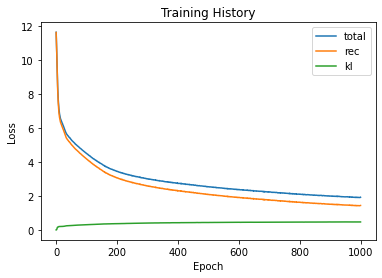

In [10]:
# Train the model using single set of hyperparameters
LEN_HH = 0
start_time = time.time()
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, CAT_IDX, LEN_HH, KL_WEIGHT, NUM_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)
train_time = (time.time()-start_time)
print(train_time)

# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl"], loc="upper right")
plt.show()

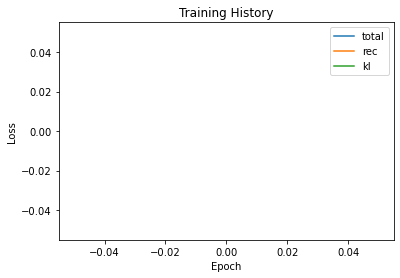

In [11]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'][1000:])
plt.plot(history.history['rec_loss'][1000:])
plt.plot(history.history['kl_loss'][1000:])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl"], loc="upper right")
plt.show()

## Testing

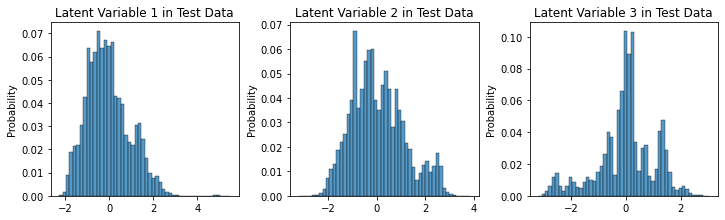

In [12]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [15]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
# print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 1.6692445278167725


In [22]:
results

[[array([[3.4340027e-01, 5.0798649e-01, 5.9581012e-02, ..., 1.8988223e-05,
          9.6465601e-06, 1.5938083e-03],
         [4.5796128e-06, 2.9818088e-07, 7.0679100e-08, ..., 7.7836913e-01,
          2.1714301e-01, 2.4032181e-04],
         [1.6724829e-05, 9.1555881e-07, 1.4977991e-07, ..., 1.0054118e-03,
          4.8079692e-02, 5.7766188e-02],
         ...,
         [9.8130367e-05, 4.0031839e-05, 5.3792599e-05, ..., 6.7375665e-09,
          7.3747179e-07, 6.6302266e-07],
         [9.6311651e-06, 3.5273329e-06, 4.8004239e-07, ..., 6.5274153e-06,
          6.4839391e-05, 3.6280438e-02],
         [4.8135303e-06, 1.1008202e-06, 7.1550221e-07, ..., 3.2064504e-06,
          3.7980506e-05, 3.8479798e-02]], dtype=float32),
  array([[9.9850452e-01, 1.4731250e-03, 5.5197761e-06, ..., 4.8553648e-08,
          2.3205251e-08, 1.5963055e-08],
         [1.2990975e-15, 5.3713171e-05, 1.9227192e-04, ..., 9.7369264e-07,
          1.3804139e-06, 8.2996689e-07],
         [4.8037632e-13, 1.3827356e-03, 1

In [25]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:
    results_df = pd.DataFrame()
    test_data_df = pd.DataFrame()
#     # Handle case where are categorical variables
#     results_num = scaler_train.inverse_transform(results[0])
#     test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
#     results_df = pd.DataFrame(results_num)
#     test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[0]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{i}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x
# else:
#     # Handle case where there are no categorical variables
#     results_num = scaler_train.inverse_transform(results)
#     test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
#     results_df = pd.DataFrame(results_num)
#     test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

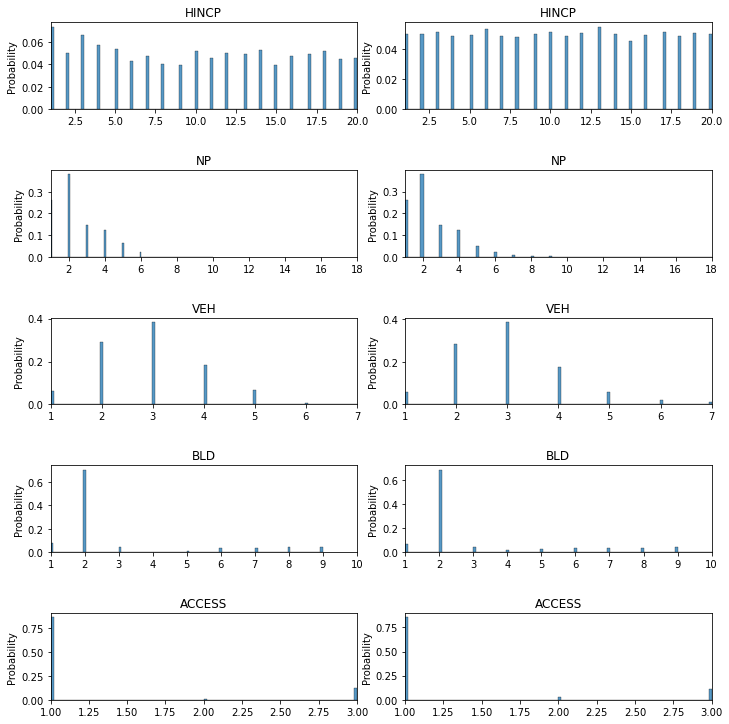

In [26]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [27]:
start_time = time.time()

# How many synthetic households to generate
POP_SIZE = 100000  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Generate households; each hh has unique latent input
results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])

print(f"--- {time.time() - start_time} seconds ---")

--- 2.0292515754699707 seconds ---


In [30]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:
    results_df = pd.DataFrame()
    test_data_df = pd.DataFrame()
#     # Handle case where are categorical variables
#     results_num = scaler_train.inverse_transform(results[0])
#     test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
#     results_df = pd.DataFrame(results_num)
#     test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[0]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{i}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x
# else:
#     # Handle case where there are no categorical variables
#     results_num = scaler_train.inverse_transform(results)
#     test_data_num = scaler_test.inverse_transform(test_data[:,:CAT_IDX])
#     results_df = pd.DataFrame(results_num)
#     test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

# In the PUMS data, VEH is indexed from 0 (sensibly). However we have just added 1 to all cat vars, so remove it
results_df['VEH'] = results_df['VEH'] - 1

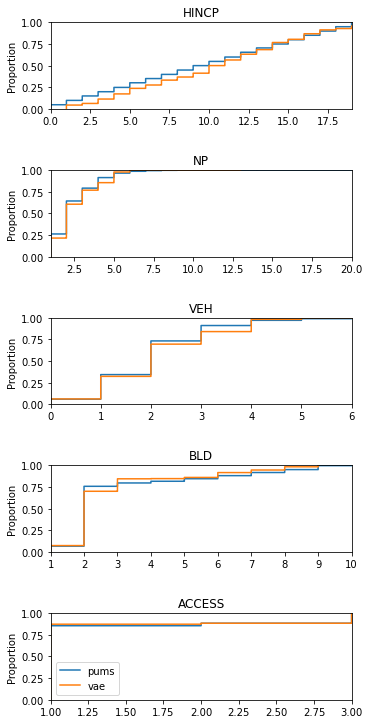

In [31]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=results_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

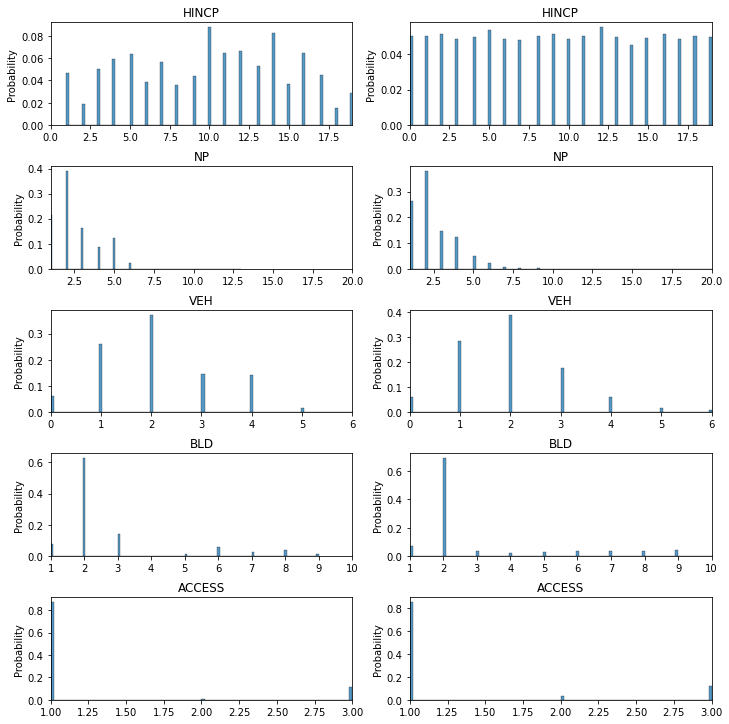

In [32]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=2, w_pad=2)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

In [33]:
for i in range(CAT_IDX):
    ks_test = stats.ks_2samp(results_df.values[:,i], pums_data.values[:,i])
    print(ks_test)
for i in range(CAT_IDX, results_df.values.shape[1]):
    unique_values, count_in_pums = np.unique(pums_data.values[:,i].astype('int'), return_counts=True)
    count_in_results = []
    for value in unique_values:
        count_in_results.append(np.count_nonzero(results_df.values[:,i].astype('int') == value))
    chisq_test = stats.chisquare(count_in_results, f_exp=count_in_pums)
    print(count_in_results)
    print(count_in_pums)
    print(chisq_test)

[0, 4632, 1878, 5065, 5930, 6404, 3861, 5645, 3576, 4421, 8762, 6474, 6649, 5285, 8239, 3666, 6434, 4445, 1550, 2893]
[7051 7045 7205 6854 6994 7516 6839 6749 7059 7181 6829 7091 7750 7009
 6383 6935 7215 6823 7059 6999]
Power_divergenceResult(statistic=27749.42786108856, pvalue=0.0)
[21567, 39061, 16191, 8677, 12315, 2149, 39, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[36973 53496 20831 17110  7241  2983  1073   474   213    96    40    27
    14     6     4     3     1     1]
Power_divergenceResult(statistic=21166.5354197898, pvalue=0.0)
[6343, 26041, 37181, 14475, 14123, 1682, 155]
[ 8489 39911 54629 24957  8460  2617  1523]
Power_divergenceResult(statistic=20691.40730242734, pvalue=0.0)
[7546, 62651, 14382, 222, 1363, 5601, 2956, 3715, 1564, 0]
[ 9660 97084  5429  2752  4121  4996  5077  4735  6397   335]
Power_divergenceResult(statistic=36776.67729494073, pvalue=0.0)
[87224, 1109, 11667]
[120132   4058  16396]
Power_divergenceResult(statistic=12521.587300077394, pvalue=0.0)


In [21]:
# Save the synthesized households
results_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
results_df

,HINCP,NP,VEH,BLD,ACCESS
0,142302.343750,3,1,2,1
1,11144.541016,4,0,8,1
2,185170.062500,4,2,2,1
3,39494.273438,2,2,8,2
4,49121.523438,5,4,2,1
...,...,...,...,...,...
99995,24646.111328,3,2,2,3
99996,28517.626953,2,2,2,3
99997,20201.099609,2,1,2,3
99998,25038.076172,1,0,6,2
